In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_preprocessing
from keras_preprocessing import image
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception,ResNet50V2,MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import CategoricalCrossentropy,CategoricalAccuracy
from tensorflow.keras.optimizers import Adam

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 16.8 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 20 05:18:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Configure the hyperparameters
input_shape = (32, 32, 3)
num_classes = 33

weight_decay = 0.0001
learning_rate = 0.0001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 30
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


In [5]:
df_train = pd.read_csv("../input/fruit-train-test-split/train_dataset.csv")
df_test = pd.read_csv("../input/fruit-train-test-split/test_dataset.csv")

dir_name = f"/kaggle/input/fruit-image/train/train/"
df_train['absolut_path'] = dir_name + df_train.path.astype(str)
df_test['absolut_path'] = dir_name + df_test.path.astype(str)

#df_train['filename'] = df_train.path.apply(lambda x : x.split("/")[-1]).astype(str)
#df_test['filename'] = df_test.path.apply(lambda x : x.split("/")[-1]).astype(str)

In [6]:
df_train.head()

path    category  \
0             Pear/Pear_267.jpg        Pear   
1           Lemon/Lemon_169.jpg       Lemon   
2         Orange/Orange_475.jpg      Orange   
3  Pepper Red/Pepper Red_55.jpg  Pepper Red   
4         Tomato/Tomato_187.jpg      Tomato   

                                        absolut_path  
0  /kaggle/input/fruit-image/train/train/Pear/Pea...  
1  /kaggle/input/fruit-image/train/train/Lemon/Le...  
2  /kaggle/input/fruit-image/train/train/Orange/O...  
3  /kaggle/input/fruit-image/train/train/Pepper R...  
4  /kaggle/input/fruit-image/train/train/Tomato/T...

In [7]:
df_test.head()

path    category  \
0  Cantaloupe/Cantaloupe_360.jpg  Cantaloupe   
1  Pepper Red/Pepper Red_403.jpg  Pepper Red   
2          Tomato/Tomato_425.jpg      Tomato   
3          Cherry/Cherry_180.jpg      Cherry   
4  Potato Red/Potato Red_170.jpg  Potato Red   

                                        absolut_path  
0  /kaggle/input/fruit-image/train/train/Cantalou...  
1  /kaggle/input/fruit-image/train/train/Pepper R...  
2  /kaggle/input/fruit-image/train/train/Tomato/T...  
3  /kaggle/input/fruit-image/train/train/Cherry/C...  
4  /kaggle/input/fruit-image/train/train/Potato R...

In [8]:
PATH = "../input/fruit-image/train/train/" #path in kaggle
TRAIN_CUT = int(len(df_train) * validation_split)

df_train_cut = df_train[0:TRAIN_CUT]
df_validate_cut = df_train[TRAIN_CUT:]

print(f"Training size: {len(df_train_cut)}")
print(f"Validate size: {len(df_validate_cut)}")

Training size: 3033
Validate size: 12135


In [9]:
def DataGeneration(Height, Width, BatchSize):
    start_time = time.time()
    training_datagen = ImageDataGenerator(
                rescale = 1./255,
                horizontal_flip = True,
                vertical_flip = True,
                rotation_range = 30,
                brightness_range = [0.8,1.5],
                zoom_range = [0.8,1.2],
                fill_mode = 'nearest')
    train_generator = training_datagen.flow_from_dataframe(
            dataframe = df_train_cut,
            directory = PATH,
            x_col="path",
            y_col="category",
            target_size = (Height, Width),
            batch_size = BatchSize,
            class_mode = 'categorical',
            shuffle = True,
            validate_filenames=False,
            seed = 98)
    validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale = 1./255)
    val_generator = validation_datagen.flow_from_dataframe(
            dataframe = df_validate_cut,
            directory = PATH,
            x_col="path",
            y_col="category",
            target_size = (Height, Width),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = True,
            validate_filenames=False,
            seed = 98)

    print(f'----{time.time()-start_time} seconds----')
    return train_generator, val_generator

In [10]:
## Warmup with Expotential Decay Learning Rate Scheduler
def scheduler(epoch):
    if epoch<= WARMUP_EPOCH:
        lr = INITIAL_LEARNINGRATE *epoch/WARMUP_EPOCH
    
    else:
        lr = INITIAL_LEARNINGRATE * DECAY_RATE**(epoch-WARMUP_EPOCH)
    
    return lr

# Transfer Learning

In [11]:
#transfer learning
def BuildModel(ModelName):
    print('--------------Building The Model...--------------')
    if ModelName == 'ResNet50V2' or ModelName == 'Xception':
        if ModelName == 'ResNet50V2':
            base_model = ResNet50V2(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(HEIGHT,WIDTH,3))
        
        elif ModelName == 'Xception':
            base_model = Xception(include_top=False,
                                                weights='imagenet',
                                                input_shape=(HEIGHT,WIDTH,3))
        
        base_model.trainable = True
        print("\nNumber of layers in the base model: ", len(base_model.layers))
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024,activation='relu')(x)
        x = tf.keras.layers.Dense(1024,activation='relu')(x)
        out = tf.keras.layers.Dense(num_classes,activation="softmax")(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=out)
        
    
    elif ModelName == 'MobileNet':
        base_model = MobileNet(include_top=False,
                                                weights='imagenet',
                                                input_shape=(HEIGHT,WIDTH,3))
        base_model.trainable = True
        print("\nNumber of layers in the base model: ", len(base_model.layers))
        
        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024,activation='relu')(x)
        x = tf.keras.layers.Dense(1024,activation='relu')(x)
        out = tf.keras.layers.Dense(num_classes,activation="softmax")(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=out)
    
    print('\n--------------Done!--------------')
    return model

In [12]:
def ModelDeployment(model, LearningRate, ModelName,  NbOfEpoch, StepsPerEpoch, ValidationSteps):
    ## Freeze all the layers before the `fine_tune_at` layer
    #for layer in base_model.layers[:fine_tune_at]:
    #    layer.trainable =  False
    print('--------------Deploying the Model...--------------')
    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=LearningRate),metrics = [CategoricalCrossentropy(name="categorical_crossentropy"),
                                                                                                 CategoricalAccuracy(name="categorical_accuracy")])
    monitor = EarlyStopping(monitor='val_loss',min_delta=1e-4,patience=10,verbose=1,mode='min',restore_best_weights=True)
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                        factor=0.5,
                                                        patience=3,
                                                        verbose=1,
                                                        mode='min',
                                                        min_delta=1e-4,
                                                        cooldown=0,
                                                        min_lr=MIN_LR,)

    filepath= ModelName+"-{epoch:02d}-{val_loss:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=False,save_weights_only=True,mode='min',save_freq = 'epoch')
    print('--------------Deployed Successfully--------------')
    print('--------------Training Begins--------------')
    history = model.fit(train_generator,epochs = NbOfEpoch,steps_per_epoch = StepsPerEpoch,validation_data = val_generator,
                        verbose = 1,validation_steps = ValidationSteps,callbacks = [monitor,lr_scheduler,checkpoint])
    return history

In [13]:
#test
HEIGHT = 150
WIDTH = 150
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=PATH,
        x_col="path",
        y_col="category",
        batch_size = 1,
        shuffle = False,
        target_size=(HEIGHT, WIDTH),
        class_mode=None)

Found 1686 validated image filenames.


**1. ResNet50V2**

In [14]:
#resnet50
HEIGHT = 150
WIDTH = 150
BATCH_SIZE = 32

train_generator, val_generator = DataGeneration(Height = HEIGHT, 
                                                Width = WIDTH,
                                                BatchSize = BATCH_SIZE)
tf.keras.backend.clear_session()

Found 3033 non-validated image filenames belonging to 33 classes.
Found 12135 non-validated image filenames belonging to 33 classes.
----0.07051324844360352 seconds----


In [15]:
Resnet_based_model = BuildModel('ResNet50V2')
#Resnet_based_model.summary()

--------------Building The Model...--------------


2021-12-20 05:18:18.568537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 05:18:18.706417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 05:18:18.707271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 05:18:18.708609: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 0s 0us/step

Number of layers in the base model:  190

--------------Done!--------------


In [16]:
STEPS_PER_EPOCH = train_generator.n//BATCH_SIZE
VALIDATION_STEPS = val_generator.n//BATCH_SIZE
LEARNING_RATE = 1e-3
NB_EPOCH = 250
MIN_LR = LEARNING_RATE/10
Resnet50_history = ModelDeployment(model = Resnet_based_model, 
                                   LearningRate = LEARNING_RATE, 
                                   ModelName = 'ResNet50V2',  
                                   NbOfEpoch = NB_EPOCH, 
                                   StepsPerEpoch = STEPS_PER_EPOCH, 
                                   ValidationSteps = VALIDATION_STEPS)

--------------Deploying the Model...--------------
--------------Deployed Successfully--------------
--------------Training Begins--------------


2021-12-20 05:18:23.439469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250


2021-12-20 05:18:29.257259: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


94/94 [==============================] - 87s 813ms/step - loss: 1.8836 - categorical_crossentropy: 1.8836 - categorical_accuracy: 0.4515 - val_loss: 20.5596 - val_categorical_crossentropy: 20.5596 - val_categorical_accuracy: 0.1373

Epoch 00001: saving model to ResNet50V2-01-20.5596.hdf5
Epoch 2/250
94/94 [==============================] - 38s 410ms/step - loss: 0.8904 - categorical_crossentropy: 0.8904 - categorical_accuracy: 0.7168 - val_loss: 11.8530 - val_categorical_crossentropy: 11.8530 - val_categorical_accuracy: 0.2186

Epoch 00002: saving model to ResNet50V2-02-11.8530.hdf5
Epoch 3/250
94/94 [==============================] - 45s 479ms/step - loss: 0.4789 - categorical_crossentropy: 0.4789 - categorical_accuracy: 0.8441 - val_loss: 9.2479 - val_categorical_crossentropy: 9.2479 - val_categorical_accuracy: 0.2368

Epoch 00003: saving model to ResNet50V2-03-9.2479.hdf5
Epoch 4/250
94/94 [==============================] - 39s 410ms/step - loss: 0.3971 - categorical_crossentropy: 0

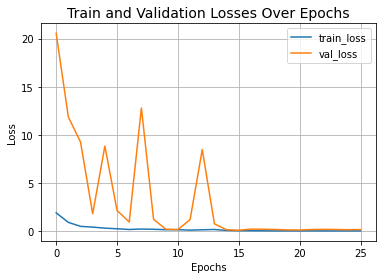

In [17]:
plt.plot(Resnet50_history.history["loss"], label="train_loss")
plt.plot(Resnet50_history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

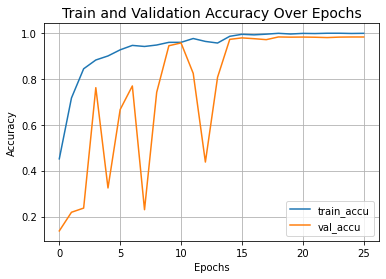

In [18]:
plt.plot(Resnet50_history.history["categorical_accuracy"], label="train_accu")
plt.plot(Resnet50_history.history["val_categorical_accuracy"], label="val_accu")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

**2. MobileNet**

In [19]:
tf.keras.backend.clear_session()

In [20]:
HEIGHT = 150
WIDTH = 150
BATCH_SIZE = 32

train_generator, val_generator = DataGeneration(Height = HEIGHT, 
                                                Width = WIDTH,
                                                BatchSize = BATCH_SIZE)

Found 3033 non-validated image filenames belonging to 33 classes.
Found 12135 non-validated image filenames belonging to 33 classes.
----0.06606554985046387 seconds----


In [21]:
MobileNet_based_model = BuildModel(ModelName='MobileNet')

--------------Building The Model...--------------
17235968/17225924 [==============================] - 0s 0us/step

Number of layers in the base model:  86

--------------Done!--------------


In [22]:
STEPS_PER_EPOCH = train_generator.n//BATCH_SIZE

VALIDATION_STEPS = val_generator.n//BATCH_SIZE

LEARNING_RATE = 1e-4
MIN_LR = LEARNING_RATE/10
NB_EPOCH = 100

MobileNet_history = ModelDeployment(model = MobileNet_based_model, 
                                   LearningRate = LEARNING_RATE, 
                                   ModelName = 'MobileNet',  
                                   NbOfEpoch = NB_EPOCH, 
                                   StepsPerEpoch = STEPS_PER_EPOCH, 
                                   ValidationSteps = VALIDATION_STEPS)

--------------Deploying the Model...--------------
--------------Deployed Successfully--------------
--------------Training Begins--------------
Epoch 1/100
94/94 [==============================] - 49s 499ms/step - loss: 1.1087 - categorical_crossentropy: 1.1087 - categorical_accuracy: 0.7514 - val_loss: 0.7344 - val_categorical_crossentropy: 0.7344 - val_categorical_accuracy: 0.7855

Epoch 00001: saving model to MobileNet-01-0.7344.hdf5
Epoch 2/100
94/94 [==============================] - 36s 383ms/step - loss: 0.0739 - categorical_crossentropy: 0.0739 - categorical_accuracy: 0.9827 - val_loss: 0.0729 - val_categorical_crossentropy: 0.0729 - val_categorical_accuracy: 0.9787

Epoch 00002: saving model to MobileNet-02-0.0729.hdf5
Epoch 3/100
94/94 [==============================] - 36s 383ms/step - loss: 0.0313 - categorical_crossentropy: 0.0313 - categorical_accuracy: 0.9913 - val_loss: 0.0111 - val_categorical_crossentropy: 0.0111 - val_categorical_accuracy: 0.9977

Epoch 00003: savin

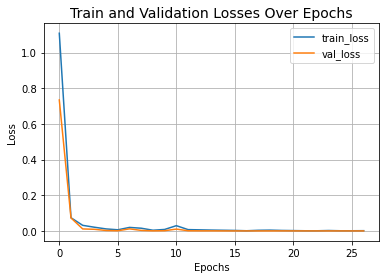

In [23]:
plt.plot(MobileNet_history.history["loss"], label="train_loss")
plt.plot(MobileNet_history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

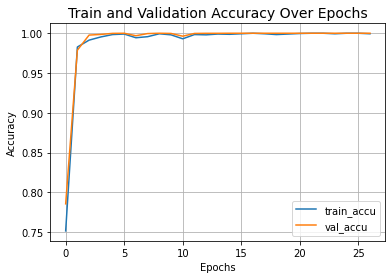

In [24]:
plt.plot(MobileNet_history.history["categorical_accuracy"], label="train_accu")
plt.plot(MobileNet_history.history["val_categorical_accuracy"], label="val_accu")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

**Evaluation**

In [25]:
Resnet_based_model = BuildModel(ModelName='ResNet50V2')
MobileNet_based_model = BuildModel(ModelName='MobileNet')

Resnet_based_model.load_weights('../input/fruit-weights/ResNet50V2-16-0.0178.hdf5')
MobileNet_based_model.load_weights('../input/fruit-weights/MobileNet-29-0.0001.hdf5')

--------------Building The Model...--------------

Number of layers in the base model:  190

--------------Done!--------------
--------------Building The Model...--------------

Number of layers in the base model:  86

--------------Done!--------------


In [26]:
#test
HEIGHT = 150
WIDTH = 150
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=PATH,
        x_col="path",
        y_col="category",
        batch_size = 128,
        shuffle = False,
        target_size=(HEIGHT, WIDTH),
        class_mode="categorical")

Found 1686 validated image filenames belonging to 33 classes.


In [27]:
LearningRate = 1e-3

Resnet_based_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=LearningRate),metrics = [CategoricalAccuracy(name="categorical_accuracy")])
MobileNet_based_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=LearningRate),metrics = [CategoricalAccuracy(name="categorical_accuracy")])

In [28]:
ResNet_score = Resnet_based_model.evaluate_generator(test_generator,len(df_test))
MobileNet_score = MobileNet_based_model.evaluate_generator(test_generator,len(df_test))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [29]:
print(f"ResNet50V2 Test Accuracy: {np.round(ResNet_score[1],3)}, Test Loss:{np.round(ResNet_score[0],3)}")

ResNet50V2 Test Accuracy: 0.985, Test Loss:0.033


In [30]:
print(f"MobileNet Test Accuracy: {np.round(MobileNet_score[1],3)}, Test Loss:{np.round(MobileNet_score[0],3)}")

MobileNet Test Accuracy: 1.0, Test Loss:0.0


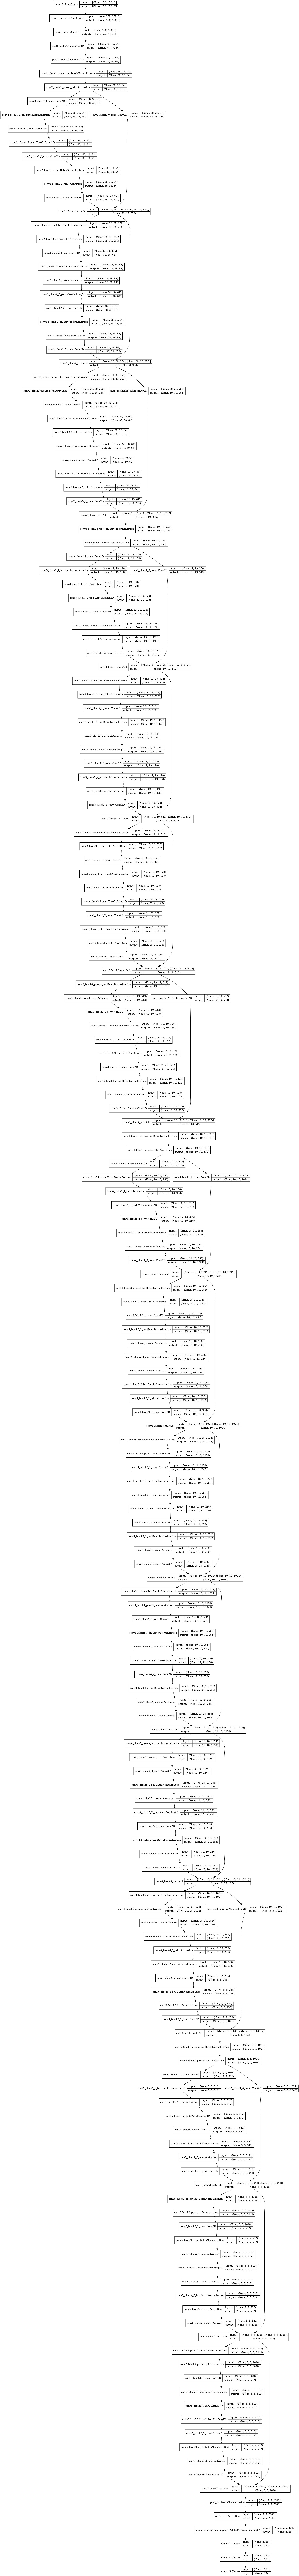

In [31]:
keras.utils.plot_model(Resnet_based_model, show_shapes=True)

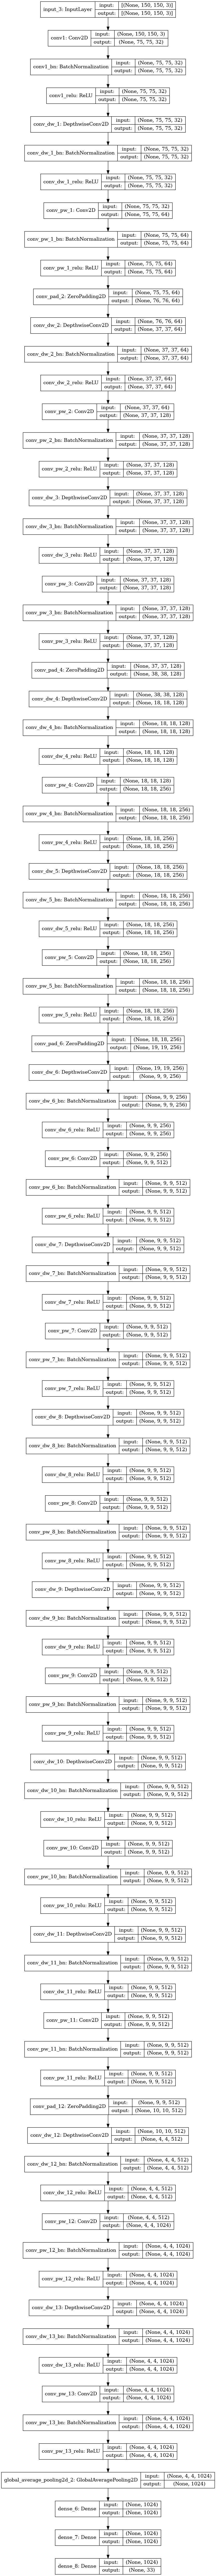

In [32]:
keras.utils.plot_model(MobileNet_based_model, show_shapes=True)